<a href="https://www.kaggle.com/code/handandegerli/scoutium-prediction-model?scriptVersionId=188555070" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Business Problem:
---
**Predicting which class (average, highlighted) a player belongs to based on the scores given to their attributes by scouts.**

The datasets consist of information from Scoutium, including the attributes and scores given by scouts to players observed during matches based on their performance in various attributes rated during the game.

**Variables of scoutium_attributes.csv**
- **task_response_id**: A set of evaluations for all players on a team by a scout in a match
- **match_id**: The ID of the related match
- **evaluator_id**: The ID of the evaluator (scout)
- **player_id**: The ID of the related player
- **position_id**: The ID of the position the player played in that match
  1. Goalkeeper
  2. Center-back
  3. Right-back
  4. Left-back
  5. Defensive midfielder
  6. Central midfielder
  7. Right winger
  8. Left winger
  9. Attacking midfielder
  10. Forward
- **analysis_id**: A set containing the attribute evaluations of a player by a scout in a match
- **attribute_id**: The ID of each attribute that players are evaluated on
- **attribute_value**: The value (score) given by a scout to a player for an attribute

**Variables of scoutium_potential_labels.csv**
- **task_response_id**: A set of evaluations for all players on a team by a scout in a match
- **match_id**: The ID of the related match
- **evaluator_id**: The ID of the evaluator (scout)
- **player_id**: The ID of the related player
- **potential_label**: The label indicating the scout's final decision about a player in a match (target variable)


---

**Step 1:** Read the `scoutium_attributes.csv` and `scoutium_potential_labels.csv` files.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)
import warnings
warnings.simplefilter(action="ignore")

In [2]:
df1 = pd.read_csv("/kaggle/input/scoutiumattributes/scoutium_attributes.csv", delimiter=";")
df1.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.000
1,4915,62935,177676,1361061,2,12818495,4323,56.000
2,4915,62935,177676,1361061,2,12818495,4324,67.000
3,4915,62935,177676,1361061,2,12818495,4325,56.000
4,4915,62935,177676,1361061,2,12818495,4326,45.000


In [3]:
df2 = pd.read_csv("/kaggle/input/scoutiumpotentiallabels/scoutium_potential_labels.csv", delimiter=";")
df2.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   task_response_id  10730 non-null  int64  
 1   match_id          10730 non-null  int64  
 2   evaluator_id      10730 non-null  int64  
 3   player_id         10730 non-null  int64  
 4   position_id       10730 non-null  int64  
 5   analysis_id       10730 non-null  int64  
 6   attribute_id      10730 non-null  int64  
 7   attribute_value   10730 non-null  float64
dtypes: float64(1), int64(7)
memory usage: 670.8 KB


In [5]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
task_response_id,10730.000,5252.082,268.254,4915.000,4997.000,5162.000,5524.000,5642.000
match_id,10730.000,63199.764,663.917,60549.000,62988.000,63166.000,63627.000,64045.000
evaluator_id,10730.000,175246.880,43667.459,130478.000,151191.000,151191.000,177676.000,256441.000
player_id,10730.000,1525548.486,201751.875,1355710.000,1367783.000,1372670.000,1719053.000,1909728.000
position_id,10730.000,5.347,2.861,1.000,3.000,6.000,8.000,10.000
analysis_id,10730.000,12822388.800,2676.866,12818481.000,12819582.000,12822231.000,12825047.000,12825764.000
attribute_id,10730.000,4348.609,26.980,4322.000,4330.000,4342.000,4353.000,4426.000
attribute_value,10730.000,55.271,16.048,1.000,45.000,56.000,67.000,100.000


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   task_response_id  322 non-null    int64 
 1   match_id          322 non-null    int64 
 2   evaluator_id      322 non-null    int64 
 3   player_id         322 non-null    int64 
 4   potential_label   322 non-null    object
dtypes: int64(4), object(1)
memory usage: 12.7+ KB


In [7]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
task_response_id,322.000,5252.003,268.947,4915.000,4998.500,5162.000,5524.000,5642.000
match_id,322.000,63198.593,666.017,60549.000,62988.000,63166.000,63627.000,64045.000
evaluator_id,322.000,175432.379,43846.028,130478.000,151191.000,151191.000,177676.000,256441.000
player_id,322.000,1525369.708,201786.908,1355710.000,1367783.000,1372671.500,1718677.750,1909728.000


**Step 2:** Merge the read CSV files using the `merge` function.Perform the merge operation based on the four variables: `task_response_id`, `match_id`, `evaluator_id`, and `player_id`.


In [8]:
df=df1.merge(df2, on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


# Feature Engineering

In [9]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

In [10]:
check_df(df)

##################### Shape #####################
(10730, 9)
##################### Types #####################
task_response_id      int64
match_id              int64
evaluator_id          int64
player_id             int64
position_id           int64
analysis_id           int64
attribute_id          int64
attribute_value     float64
potential_label      object
dtype: object
##################### Head #####################
   task_response_id  match_id  evaluator_id  player_id  position_id  analysis_id  attribute_id  attribute_value potential_label
0              4915     62935        177676    1361061            2     12818495          4322           56.000         average
1              4915     62935        177676    1361061            2     12818495          4323           56.000         average
2              4915     62935        177676    1361061            2     12818495          4324           67.000         average
##################### Tail #####################
       task_r

**Step 3:**Remove the Goalkeeper (1) class from the `position_id` column in the dataset.

In [11]:
df = df.loc[~(df["position_id"] == 1)]
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [12]:
df["position_id"].unique()

array([ 2, 10,  6,  5,  9,  7,  4,  3,  8])

**Step 4:** Remove the `below_average` class from the `potential_label` column in the dataset (the `below_average` class constitutes 1% of the entire dataset).

In [13]:
df = df.loc[~(df["potential_label"] == "below_average")]
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [14]:
df["potential_label"].unique()

array(['average', 'highlighted'], dtype=object)

In [15]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, cat_but_car, num_cols

In [16]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 9894
Variables: 9
cat_cols: 2
num_cols: 7
cat_but_car: 0
num_but_cat: 1


In [17]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


In [18]:
for col in cat_cols:
    cat_summary(df, col)

                 potential_label  Ratio
potential_label                        
average                     7922 80.069
highlighted                 1972 19.931
             position_id  Ratio
position_id                    
2                   1972 19.931
6                   1428 14.433
10                  1054 10.653
8                    986  9.966
7                    986  9.966
3                    952  9.622
9                    850  8.591
4                    850  8.591
5                    816  8.247


In [19]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->")

count   9894.000
mean    5253.674
std      268.122
min     4915.000
5%      4919.000
10%     4929.000
20%     4970.000
30%     5005.000
40%     5119.000
50%     5162.000
60%     5319.000
70%     5523.000
80%     5579.000
90%     5621.000
95%     5639.000
99%     5642.000
max     5642.000
Name: task_response_id, dtype: float64


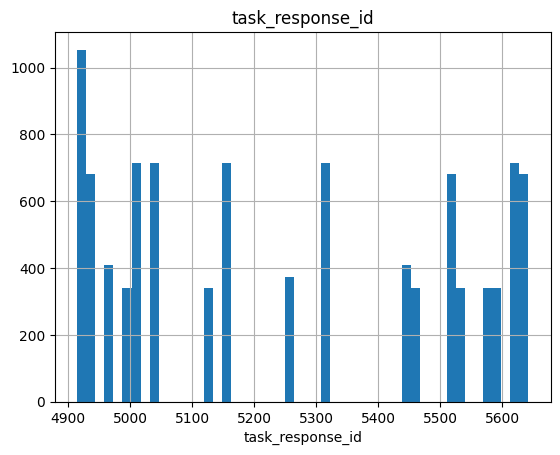

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count    9894.000
mean    63199.093
std       666.085
min     60549.000
5%      61923.000
10%     62935.000
20%     62944.000
30%     63032.000
40%     63058.000
50%     63166.000
60%     63406.000
70%     63556.000
80%     63696.000
90%     63930.000
95%     64045.000
99%     64045.000
max     64045.000
Name: match_id, dtype: float64


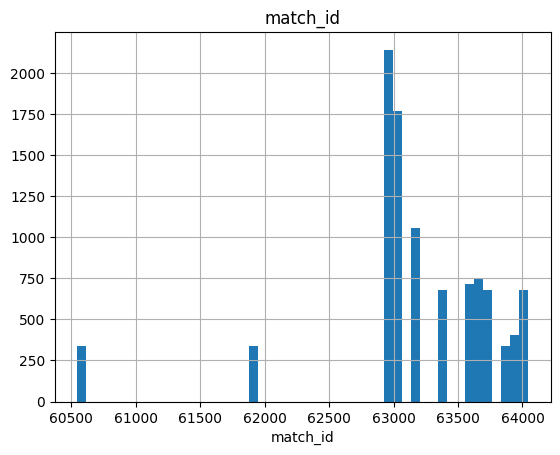

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count     9894.000
mean    175284.113
std      43563.191
min     130478.000
5%      132337.000
10%     132337.000
20%     151191.000
30%     151191.000
40%     151191.000
50%     151191.000
60%     160289.000
70%     177676.000
80%     256441.000
90%     256441.000
95%     256441.000
99%     256441.000
max     256441.000
Name: evaluator_id, dtype: float64


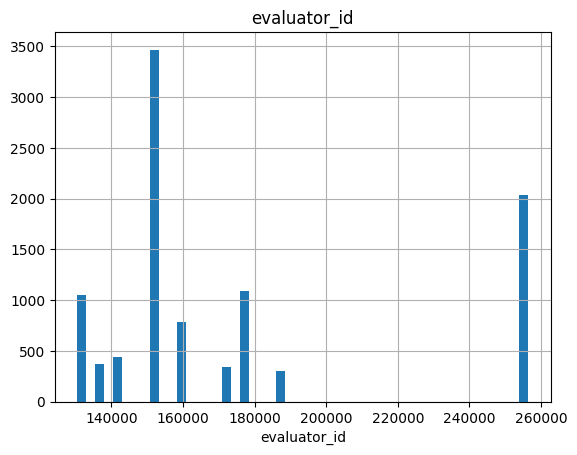

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count      9894.000
mean    1528313.031
std      203116.033
min     1355710.000
5%      1359394.000
10%     1361549.000
20%     1367544.000
30%     1369067.000
40%     1370976.000
50%     1372673.000
60%     1450931.000
70%     1717976.000
80%     1785482.000
90%     1818252.000
95%     1863235.000
99%     1909532.000
max     1909728.000
Name: player_id, dtype: float64


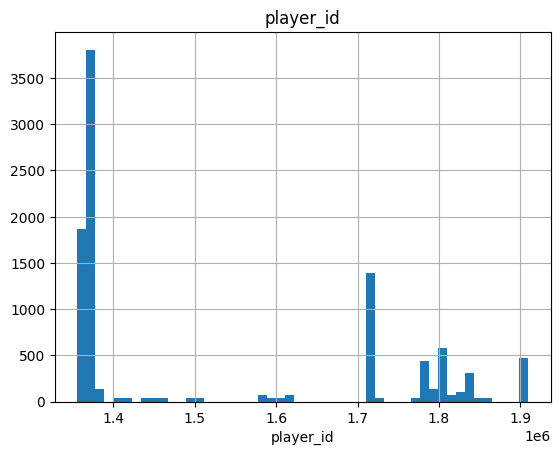

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count       9894.000
mean    12822406.069
std         2673.436
min     12818484.000
5%      12818552.000
10%     12818773.000
20%     12819199.000
30%     12819741.000
40%     12821973.000
50%     12822231.000
60%     12823687.000
70%     12825028.000
80%     12825303.000
90%     12825548.000
95%     12825724.000
99%     12825761.000
max     12825763.000
Name: analysis_id, dtype: float64


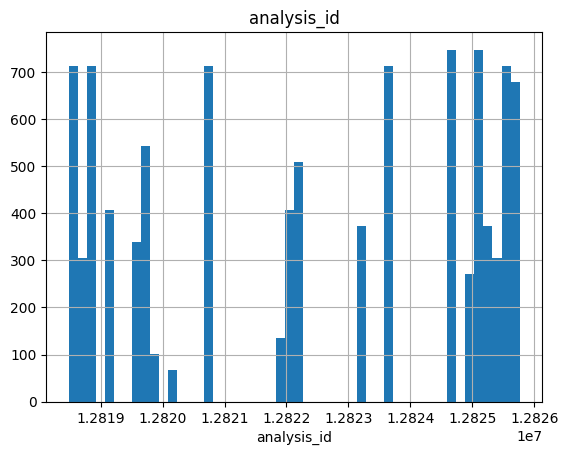

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   9894.000
mean    4348.676
std       26.848
min     4322.000
5%      4323.000
10%     4325.000
20%     4328.000
30%     4333.000
40%     4339.000
50%     4342.500
60%     4348.000
70%     4351.000
80%     4355.000
90%     4407.000
95%     4423.000
99%     4426.000
max     4426.000
Name: attribute_id, dtype: float64


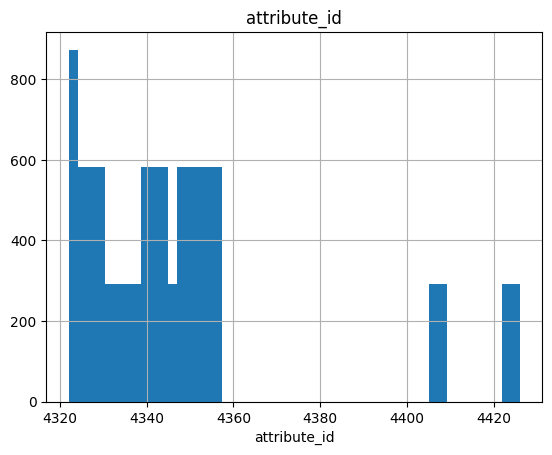

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->
count   9894.000
mean      55.522
std       15.942
min        1.000
5%        23.000
10%       34.000
20%       45.000
30%       45.000
40%       56.000
50%       56.000
60%       67.000
70%       67.000
80%       67.000
90%       78.000
95%       78.000
99%       78.000
max      100.000
Name: attribute_value, dtype: float64


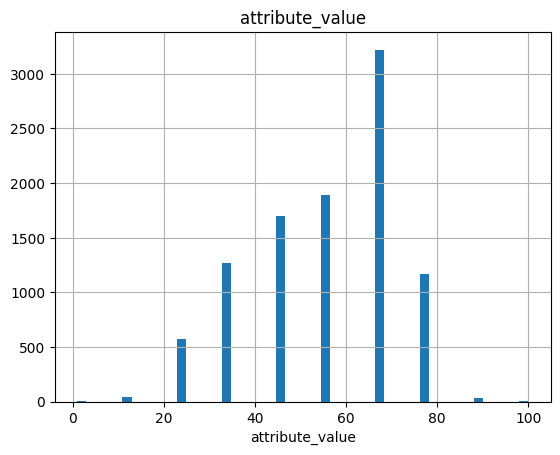

<-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><-><->


In [20]:
for col in num_cols:
    num_summary(df, col, True)

**Step 5:** Create a table from the dataset you created using the `pivot_table` function. Manipulate the pivot table so that each row represents a player.Create a pivot table with the following specifications:
- Index: `player_id`, `position_id`, and `potential_label`
- Columns: `attribute_id`
- Values: The scores given by scouts to players (`attribute_value`)

Use the `reset_index` function to assign the indices as variables and convert the names of the `attribute_id` columns to strings.


In [21]:
pivot_df = pd.pivot_table(df, values="attribute_value", index=["player_id", "position_id", "potential_label"], columns=["attribute_id"])
pivot_df.head()

attribute_id                            4322   4323   4324   4325   4326   4327   4328   4329   4330   4332   4333   4335   4338   4339   4340   4341   4342   4343   4344   4345   4348   4349   4350   4351   4352   4353   4354   4355   4356   4357   4407   4408   4423   4426
player_id position_id potential_label                                                                                                                                                                                                                                              
1355710   7           average         50.500 50.500 34.000 50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000 39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500 28.500 45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000 56.000 34.000 34.000 56.000
1356362   9           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000
1356375   3           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000 67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000 56.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000
          4           average         67.000 78.000 67.000 67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000 78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000 56.000 67.000 45.000 56.000
1356411   9           average         67.000 67.000 78.000 78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000 67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000 67.000 56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000 89.000 56.000 67.000 78.000

In [22]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 271 entries, (1355710, 7, 'average') to (1909728, 7, 'highlighted')
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   4322    271 non-null    float64
 1   4323    271 non-null    float64
 2   4324    271 non-null    float64
 3   4325    271 non-null    float64
 4   4326    271 non-null    float64
 5   4327    271 non-null    float64
 6   4328    271 non-null    float64
 7   4329    271 non-null    float64
 8   4330    271 non-null    float64
 9   4332    271 non-null    float64
 10  4333    271 non-null    float64
 11  4335    271 non-null    float64
 12  4338    271 non-null    float64
 13  4339    271 non-null    float64
 14  4340    271 non-null    float64
 15  4341    271 non-null    float64
 16  4342    271 non-null    float64
 17  4343    271 non-null    float64
 18  4344    271 non-null    float64
 19  4345    271 non-null    float64
 20  4348    271 non-null    float6

In [23]:
pivot_df = pivot_df.reset_index()
pivot_df.columns = pivot_df.columns.astype(str)
pivot_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


**Step 6:** Use the Label Encoder function to numerically represent the categories of `potential_label` (average, highlighted).

In [24]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
pivot_df["potential_label"] = LabelEncoder().fit_transform(pivot_df["potential_label"])
pivot_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,0,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,0,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


**Step 7:**Assign the numerical variable columns to a list named `num_cols`.

In [25]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                        dataframe[col].dtypes != "O"]
    
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                        dataframe[col].dtypes == "O"]
    
    cat_cols = cat_cols + num_but_cat
    
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [26]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(pivot_df)

Observations: 271
Variables: 37
cat_cols: 7
num_cols: 30
cat_but_car: 0
num_but_cat: 7


In [27]:
num_cols.remove("player_id")

**Step 8:** Apply StandardScaler to scale the data in all `num_cols` variables you have saved.

In [28]:
pivot_df[num_cols] = StandardScaler().fit_transform(pivot_df[num_cols])
pivot_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.543,-0.559,34.000,-0.438,-0.767,-0.795,45.000,-0.792,-0.446,-0.123,-1.224,-1.036,-1.126,-1.009,-0.542,-0.690,-0.535,-1.067,-1.206,-1.005,-1.314,-1.042,-0.693,-0.436,56.000,-1.282,-1.132,-0.495,-1.235,34.000,-0.143,-1.487,34.000,-0.253
1,1356362,9,0,0.595,0.561,67.000,0.683,0.723,0.723,67.000,0.404,0.728,0.691,0.459,0.996,0.632,0.840,0.912,0.799,0.588,1.230,0.750,0.742,0.879,0.670,0.848,0.717,67.000,0.814,1.053,0.632,0.915,67.000,0.530,0.669,56.000,1.042
2,1356375,3,0,0.595,0.561,67.000,0.683,0.723,0.723,67.000,1.002,0.728,0.691,1.132,0.319,0.632,0.840,0.912,0.799,0.588,0.574,0.750,0.742,0.879,0.670,0.077,0.717,67.000,0.814,1.053,0.632,0.915,67.000,0.530,0.669,56.000,1.042
3,1356375,4,0,0.595,1.308,67.000,0.683,0.723,1.482,78.000,1.002,-0.055,0.691,0.459,0.996,1.335,1.580,0.185,0.799,0.588,-0.083,0.098,0.043,0.879,1.355,0.848,0.717,78.000,0.814,0.428,0.632,0.198,67.000,-0.143,0.669,45.000,-0.253
4,1356411,9,0,0.595,0.561,78.000,1.430,0.723,0.723,67.000,0.404,2.294,1.505,0.459,0.996,0.632,0.101,0.185,0.799,1.337,0.574,0.750,0.742,0.252,1.355,0.077,0.717,67.000,0.115,0.428,0.632,0.198,67.000,1.874,-0.050,67.000,1.042


**Step 9:** Develop a machine learning model that predicts the potential labels of players with minimal error based on the available dataset. Print the metrics: Roc_auc, f1, precision, recall, and accuracy.

# ML Modelling

In [29]:
X = pivot_df.drop(["potential_label", "player_id"], axis=1)
y = pivot_df["potential_label"]

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# If ANN gives some errors about features, use this codes.
"""sc = StandardScaler()
Xtrain_scaled = sc.fit_transform(X_train.values.reshape(-1,1))
Xtest_scaled = sc.fit_transform(X_test.values.reshape(-1,1))"""

'sc = StandardScaler()\nXtrain_scaled = sc.fit_transform(X_train.values.reshape(-1,1))\nXtest_scaled = sc.fit_transform(X_test.values.reshape(-1,1))'

In [33]:
! pip install xgboost

In [34]:
! pip install lightgbm

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix,accuracy_score,mean_absolute_error,mean_squared_error,r2_score,log_loss,f1_score,jaccard_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [36]:
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier(n_estimators=200)),
          ('SVR', SVC()),
          ('GBM', GradientBoostingClassifier(n_estimators=200, learning_rate=0.08)),
          ("XGBoost", XGBClassifier()),
          ("LightGBM", LGBMClassifier())]

In [37]:
acclist=[]
for name, model in models:
    acc = np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy"))
    acclist.append([name,acc])
    print(f"ACC: {round(acc, 4)} ({name}) ")

ACC: 0.8425 (LR) 
ACC: 0.7778 (KNN) 
ACC: 0.8146 (CART) 
ACC: 0.8704 (RF) 
ACC: 0.7916 (SVR) 
ACC: 0.8516 (GBM) 
ACC: 0.8795 (XGBoost) 
[LightGBM] [Info] Number of positive: 36, number of negative: 136
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 172, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.209302 -> initscore=-1.329136
[LightGBM] [Info] Start training from score -1.329136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

## LGBM 

In [38]:
lgbm = LGBMClassifier()
lgbm_params = {
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1500]}
lgbm_gs_best = GridSearchCV(lgbm, lgbm_params, cv=3, n_jobs=-1).fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 30, number of negative: 114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208333 -> initscore=-1.335001
[LightGBM] [Info] Start training from score -1.335001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [39]:
lgbm = LGBMClassifier(**lgbm_gs_best.best_params_)
lgbm.fit(X_train, y_train)
lgbm.score(X_test, y_test)

[LightGBM] [Info] Number of positive: 45, number of negative: 171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 216, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.208333 -> initscore=-1.335001
[LightGBM] [Info] Start training from score -1.335001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.8909090909090909

In [40]:
lgbm_pred=lgbm.predict(X_test)
lgbm_pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])

**Step 9:** Develop a machine learning model that predicts the potential labels of players with minimal error based on the available dataset. Print the metrics: Roc_auc, f1, precision, recall, and accuracy.

In [41]:
accuracy = accuracy_score(y_test, lgbm_pred)
precision = precision_score(y_test, lgbm_pred)
recall = recall_score(y_test, lgbm_pred)
f1 = f1_score(y_test, lgbm_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8909090909090909
Precision: 0.8571428571428571
Recall: 0.5454545454545454
F1 Score: 0.6666666666666665


**Step 10:** Use the feature_importance function to plot the ranking of features according to their importance.

In [42]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

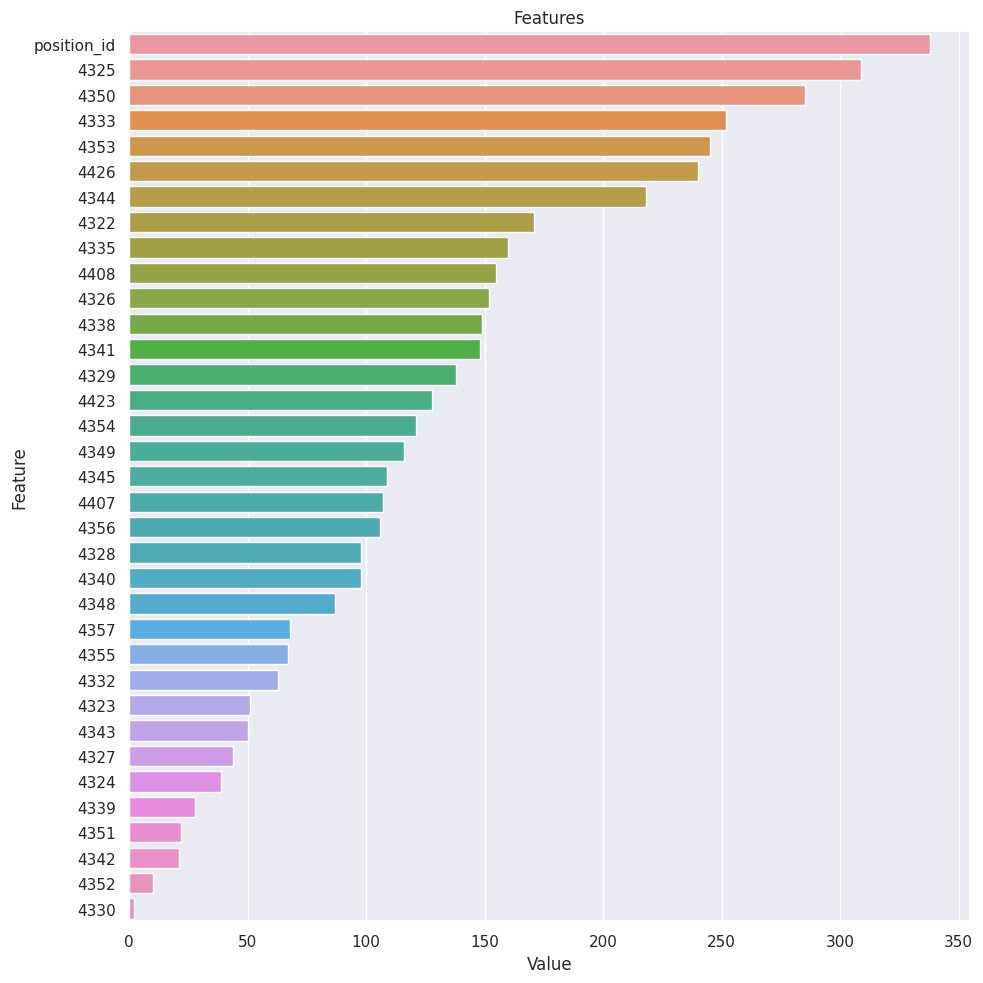

In [43]:
plot_importance(lgbm, X)

## XGBOOST

In [44]:
xgb = XGBClassifier()
xgb_params = {
    "learning_rate": [0.01, 0.1],
    "max_depth":[3,5],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 1.0],
    "n_estimators": [500, 1500,]}
xgb_gs_best = GridSearchCV(xgb, xgb_params, cv=3, n_jobs=-1).fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:57:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:57:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:57:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:57:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:57:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_features" } are not used.



In [45]:
xgb = XGBClassifier(**xgb_gs_best.best_params_)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.8909090909090909

In [46]:
xgb_pred=xgb.predict(X_test)
xgb_pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

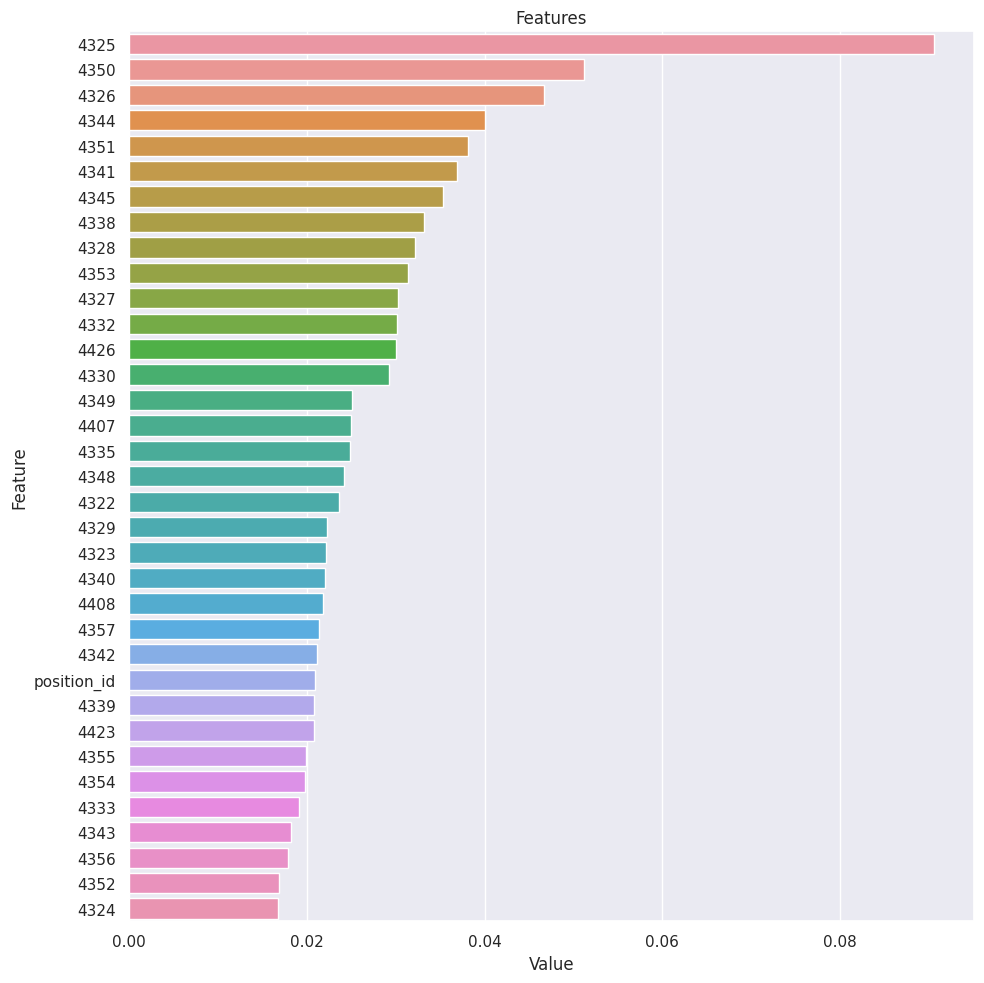

In [47]:
plot_importance(xgb, X)